In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/My Drive/Fuel_cell_performance_data-Full.csv')

In [5]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Target1,Target2,Target3,Target4,Target5
0,52.9,1.33,49.1,37.13,129.43,35.0,0.281,112.7,207,0.55,98.971,2.87,1362,15.9,429,0.959,1.531,79.3,4.19,33.29
1,87.6,2.12,48.8,42.10,171.07,37.6,0.153,157.4,188,0.86,101.179,2.34,5130,26.1,1819,0.728,1.690,57.2,5.19,34.50
2,73.3,2.72,93.8,20.11,163.69,44.3,0.367,348.7,270,1.87,98.919,2.13,7811,16.7,1763,0.784,1.865,61.6,7.77,129.28
3,65.6,2.58,48.1,35.11,63.37,32.5,0.279,321.2,322,1.75,101.560,2.91,1641,32.1,203,0.884,1.920,71.3,8.40,186.65
4,39.6,2.58,49.3,32.93,63.40,47.0,0.149,205.6,203,1.55,98.148,1.93,7648,27.5,276,0.736,1.711,58.5,4.75,52.32


In [6]:
# Select the target as given below (and drop other targets)
# Target1 - Roll Numbers ending with 0 or 5
# Target2 - Roll Numbers ending with 1 or 6
# Target3 - Roll Numbers ending with 2 or 7
# Target4 - Roll Numbers ending with 3 or 8
# Target5 - Roll Numbers ending with 4 or 9
df['pseudo_roll'] = df.index
def select_target(roll):
    last_digit = roll % 10
    if last_digit in [0, 5]:
        return 'Target1'
    elif last_digit in [1, 6]:
        return 'Target2'
    elif last_digit in [2, 7]:
        return 'Target3'
    elif last_digit in [3, 8]:
        return 'Target4'
    elif last_digit in [4, 9]:
        return 'Target5'

**Pre-process the dataset**

In [7]:
# check for null values
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col] = df[col].fillna(df[col].mean())
print("Total null values:", df.isnull().sum().sum())

Total null values: 0


In [8]:
df = df.select_dtypes(include=['number'])

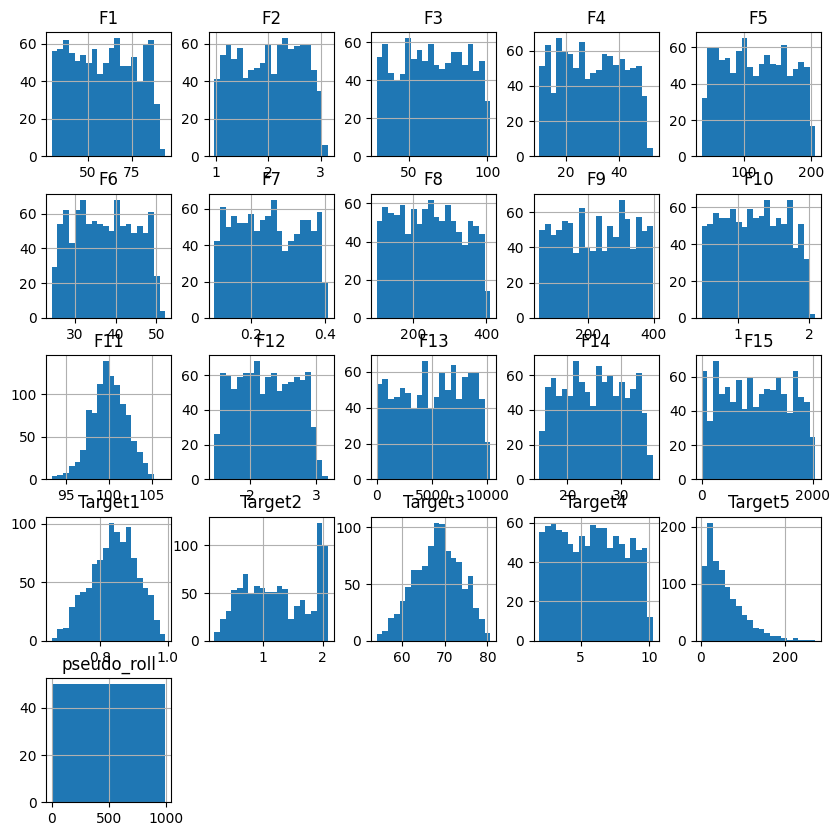

In [9]:
df.hist(bins=20, figsize=(10, 10))
plt.show()

In [10]:
for col in df.columns:
  if df[col].dtype == 'object':
    try:
      df[col] = pd.to_numeric(df[col], errors='coerce')
    except:
      pass

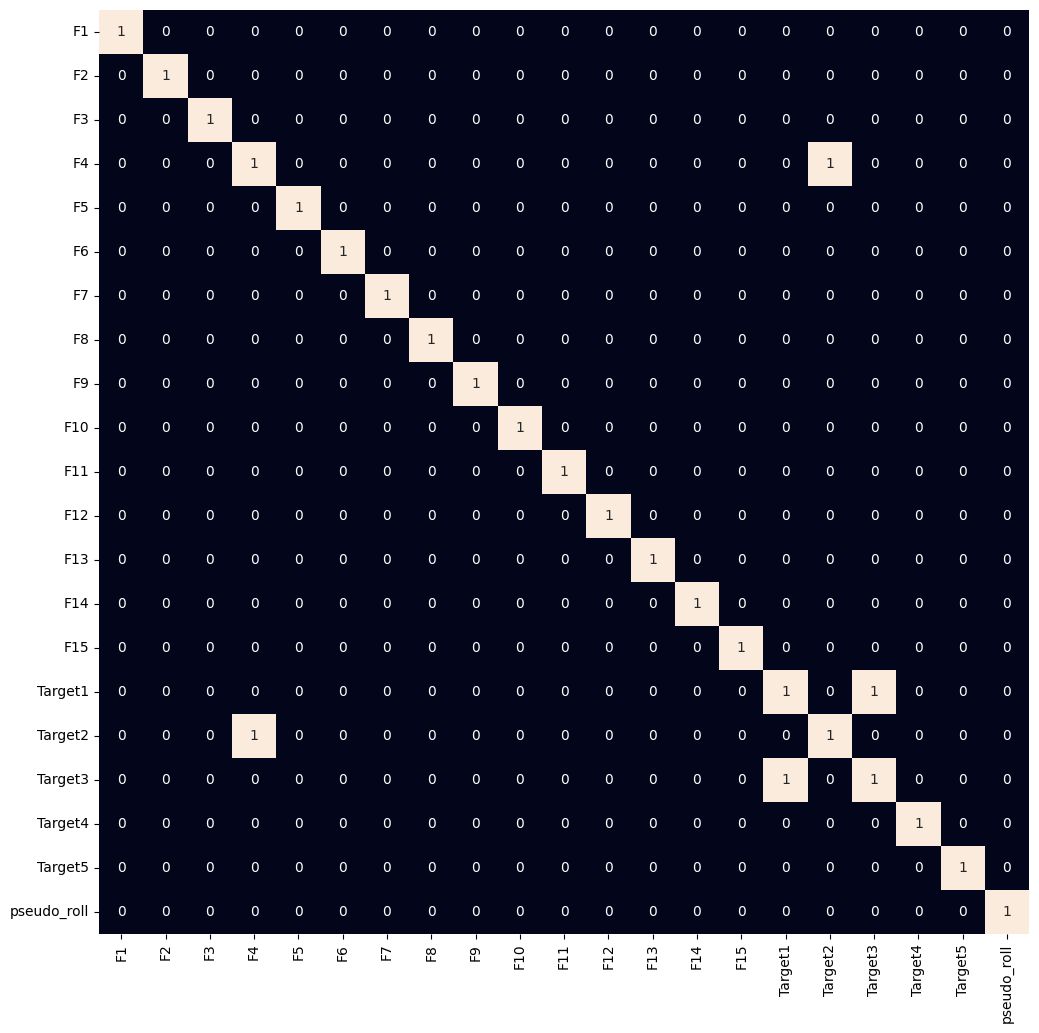

In [11]:
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr > 0.7, annot=True, cbar=False)
plt.show()

In [12]:
print(df.columns)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target1', 'Target2', 'Target3', 'Target4',
       'Target5', 'pseudo_roll'],
      dtype='object')


In [13]:
df['SelectedTargetCol'] = df['pseudo_roll'].apply(select_target)
df['Target'] = df.apply(lambda row: row[row['SelectedTargetCol']], axis=1)

# Drop other target columns
df = df.drop(columns=['Target1','Target2','Target3','Target4','Target5','SelectedTargetCol','pseudo_roll'])

In [14]:
# install pycaret to compare models
!pip install pycaret

In [15]:
print(df['Target'].value_counts())

Target
68.600     4
69.900     4
69.600     4
0.887      4
0.838      4
          ..
1.947      1
78.700     1
2.230      1
102.370    1
5.590      1
Name: count, Length: 800, dtype: int64


In [16]:
from pycaret.regression import setup, compare_models, pull, finalize_model, predict_model

In [17]:
# Initialize for regression
reg_setup = setup(data=df, target='Target', session_id=42, preprocess=True, verbose=False)

In [18]:
print(df.columns)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target'],
      dtype='object')


In [19]:
best_models = compare_models(sort='R2', n_select=10, fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,28.8257,1150.6197,33.8776,0.0018,1.8438,11.5672,0.0660
lasso,Lasso Regression,28.6468,1153.1883,33.9242,-0.0020,1.8396,11.4715,0.0260
llar,Lasso Least Angle Regression,28.6468,1153.1883,33.9242,-0.0020,1.8396,11.4715,0.0360
en,Elastic Net,28.6449,1153.7172,33.9323,-0.0025,1.8392,11.4551,0.0360
ridge,Ridge Regression,28.4622,1154.6667,33.9468,-0.0035,1.8345,11.4059,0.0260
lr,Linear Regression,28.4560,1155.2368,33.9547,-0.0040,1.8346,11.4064,0.9420
lar,Least Angle Regression,28.4497,1156.9989,33.9800,-0.0054,1.8343,11.3986,0.0280
dummy,Dummy Regressor,29.2651,1168.2968,34.1229,-0.0119,1.8584,11.6675,0.0360
omp,Orthogonal Matching Pursuit,29.2769,1168.5772,34.1268,-0.0121,1.8586,11.6716,0.0420
et,Extra Trees Regressor,29.4039,1205.5424,34.6907,-0.0481,1.8752,12.2455,0.3300


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

In [20]:
results = pull()
results = results[['Model', 'R2', 'RMSE', 'MAE']]
print(results)

                                    Model      R2     RMSE      MAE
br                         Bayesian Ridge  0.0018  33.8776  28.8257
lasso                    Lasso Regression -0.0020  33.9242  28.6468
llar         Lasso Least Angle Regression -0.0020  33.9242  28.6468
en                            Elastic Net -0.0025  33.9323  28.6449
ridge                    Ridge Regression -0.0035  33.9468  28.4622
lr                      Linear Regression -0.0040  33.9547  28.4560
lar                Least Angle Regression -0.0054  33.9800  28.4497
dummy                     Dummy Regressor -0.0119  34.1229  29.2651
omp           Orthogonal Matching Pursuit -0.0121  34.1268  29.2769
et                  Extra Trees Regressor -0.0481  34.6907  29.4039
rf                Random Forest Regressor -0.0805  35.2024  29.6055
ada                    AdaBoost Regressor -0.0955  35.4345  31.9172
gbr           Gradient Boosting Regressor -0.1222  35.8643  29.6460
lightgbm  Light Gradient Boosting Machine -0.128

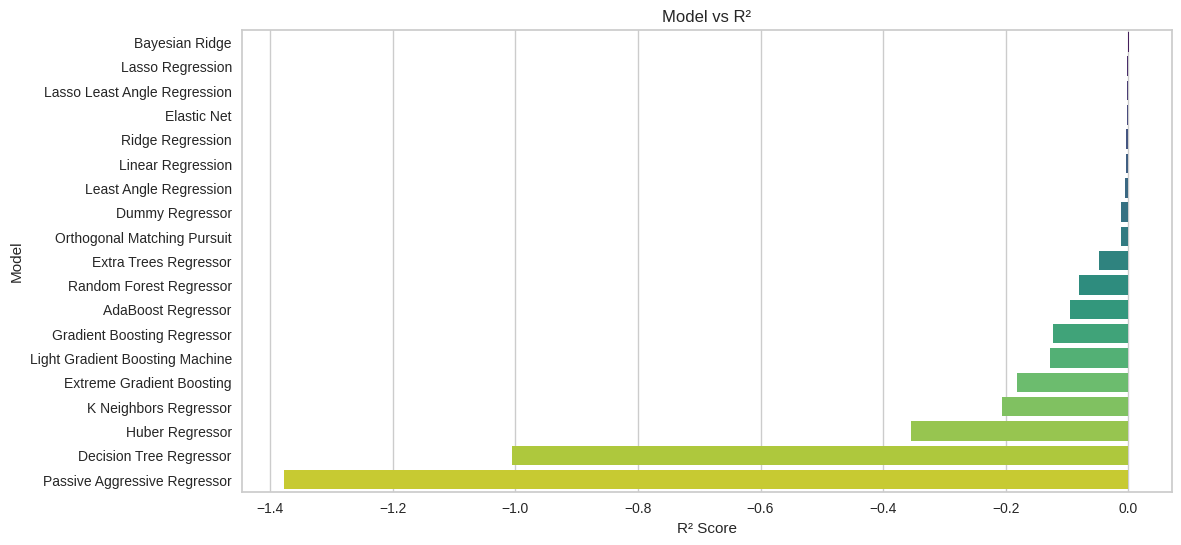

In [21]:
# Plot Model vs R2
plt.figure(figsize=(12, 6))
sns.barplot(x='R2', y='Model', data=results, palette='viridis')
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Model vs R²")
plt.show()

In [22]:
X = df.drop(columns=['Target'])
y = df['Target']

# Divide the dataset into 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Select the best model
final_model = finalize_model(best_models[0])

In [23]:
predictions = predict_model(final_model, data=test_data)
print("Predictions and Evaluation on Test Data:")
print(predictions.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,29.4999,1422.9062,37.7214,0.0833,1.8255,11.9217


Predictions and Evaluation on Test Data:
            F1    F2         F3         F4          F5         F6     F7  \
521  53.299999  2.96  39.799999  29.850000  132.610001  39.200001  0.168   
737  79.400002  1.34  67.699997  38.540001   95.220001  31.799999  0.100   
740  57.400002  2.64  57.200001  47.099998  153.100006  46.599998  0.156   
660  52.299999  2.27  64.099998  29.330000  123.169998  30.000000  0.266   
411  87.199997  1.24  40.599998  15.390000   40.860001  32.099998  0.202   

             F8   F9   F10         F11   F12   F13        F14   F15  \
521  250.199997  148  0.99   98.070000  2.33  5382  23.500000  1706   
737  163.300003  198  0.99  102.834999  2.15  7648  26.299999  1675   
740  268.100006  294  1.73  101.441002  1.90   852  25.799999  1203   
660  108.099998  385  1.54  100.304001  2.82  8513  18.400000  1641   
411  232.600006  302  1.54   99.363998  2.82  5708  23.100000   428   

        Target  prediction_label  
521   1.732000         21.850124  
737  

In [24]:
predictions = predict_model(final_model, data=test_data)
print("Columns returned by predict_model:", predictions.columns)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,29.4999,1422.9062,37.7214,0.0833,1.8255,11.9217


Columns returned by predict_model: Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target', 'prediction_label'],
      dtype='object')


In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y_true = predictions['Target']
y_pred = predictions['prediction_label']
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_true, y_pred)
print("R² = ", r2)
print("RMSE = ", rmse)
print("MAE = ", mae)

R² =  0.08327689831249319
RMSE =  37.72142877185208
MAE =  29.49990904852934
